<a href="https://www.kaggle.com/code/tarekyahia/arabicner-sen?scriptVersionId=159349361" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

### besmy allah

In [1]:
!pip install seqeval

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 3.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... - \ | done
  Created wheel for seqeval: filename=seqeval-1.2.2-py3-none-any.whl size=16162 sha256=cfda22ec2423934ba4b79f4236749c2cac9e584ef7dfadebdb0ff979669dc44e
  Stored in directory: /root/.cache/pip/wheels/1a/67/4a/ad4082dd7dfc30f2abfe4d80a2ed5926a506eb8a972b4767fa
Successfully built seqeval


In [2]:
from datasets import get_dataset_config_names
from datasets import load_dataset,ClassLabel,concatenate_datasets
from collections import defaultdict
from datasets import DatasetDict, Dataset
from collections import Counter
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re

import torch
import torch.nn as nn
from transformers import XLMRobertaConfig
from transformers.modeling_outputs import TokenClassifierOutput
from transformers.models.roberta.modeling_roberta import RobertaModel
from transformers.models.roberta.modeling_roberta import RobertaPreTrainedModel
from transformers import AutoConfig
from transformers import AutoTokenizer
from transformers import DataCollatorForTokenClassification
from transformers import TrainingArguments
from transformers import Trainer
from transformers import pipeline

import os
os.environ["WANDB_DISABLED"] = "true"

from seqeval.metrics import classification_report
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
from seqeval.metrics import f1_score



bert_model_name = "bert-base-cased"
xlmr_model_name = "xlm-roberta-base"
xlmr_tokenizer = AutoTokenizer.from_pretrained(xlmr_model_name)

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


config.json:   0%|          | 0.00/615 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.10M [00:00<?, ?B/s]

In [3]:
# prepare the second ds
dump_chars = '!"#$%&\'()*+,-./:;<=>?@[\]^_`{|}~’،ـ؟؛«» '

def clean_word(word):
    word = word.translate(str.maketrans({key: None for key in dump_chars}))

    #remove tashkeel
    p_tashkeel = re.compile(r'[\u0617-\u061A\u064B-\u0652]')
    word = re.sub(p_tashkeel,"", word)

    return word



def load_data():
    path = '/kaggle/input/anercorp/ANERCorp.txt'
    f = open(path, 'r')
    sents = f.read().split('\n. O\n')
    f.close()

    # tokenize words
    words = [None]*len(sents)
    tokens = [None]*len(sents)
    for i, sent in enumerate(sents):
        sent = sent.split('\n')
        words[i] = []
        tokens[i] = []
        for word in sent:
            line = word.rsplit(' ', 1)
            line[0] = clean_word(line[0])
            if len(line[0]) > 0:
                words[i].append(line[0])
                tokens[i].append(line[1])


    return [d for d in words if len(d) > 0], [d for d in tokens if len(d) > 0]

# load data
sents, labels = load_data()

In [4]:
pairs = list(zip(sents, labels))
df = pd.DataFrame(pairs, columns=['tokens', 'ner_tags_str'])
print(f"tokens : {df.iloc[0]['tokens']}")

tokens : ['فرانكفورت', 'د', 'ب', 'أ', 'أعلن', 'اتحاد', 'صناعة', 'السيارات', 'في', 'ألمانيا', 'امس', 'الاول', 'أن', 'شركات', 'صناعة', 'السيارات', 'في', 'ألمانيا', 'تواجه', 'عاما', 'صعبا', 'في', 'ظل', 'ركود', 'السوق', 'الداخلية', 'والصادرات', 'وهي', 'تسعي', 'لان', 'يبلغ', 'الانتاج', 'حوالي', 'خمسة', 'ملايين', 'سيارة', 'في', 'عام', '2002']


In [5]:
arb_ds = Dataset.from_pandas(df)
arb_ds

Dataset({
    features: ['tokens', 'ner_tags_str'],
    num_rows: 4898
})

In [6]:
# arabic dataset from xtreme and the hebrew
# xtreme dataset
xtreme_subsets = get_dataset_config_names("xtreme")
print(f"XTREME has {len(xtreme_subsets)} configurations")

XTREME has 183 configurations


In [7]:
# PAN datasets
panx_subsets = [s for s in xtreme_subsets if s.startswith("PAN")]
panx_subsets[:3]

['PAN-X.af', 'PAN-X.ar', 'PAN-X.bg']

In [8]:
# load the dataset
langs = ["ar", "he"]
# Return a DatasetDict if a key doesn't exist
dds = defaultdict(DatasetDict) # if the key dose not exist, create it with DatesetDict object

for lang in langs:
    # Load monolingual corpus
    ds = load_dataset("xtreme", name=f"PAN-X.{lang}")
    # Shuffle and downsample each split according to spoken proportion
    for split in ds:
        dds[lang][split] = ds[split].shuffle(seed=0).select(range(int(ds[split].num_rows)))

Generating train split:   0%|          | 0/20000 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/10000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/10000 [00:00<?, ? examples/s]

Dataset xtreme downloaded and prepared to /root/.cache/huggingface/datasets/xtreme/PAN-X.ar/1.0.0/349258adc25bb45e47de193222f95e68a44f7a7ab53c4283b3f007208a11bf7e. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

Generating train split:   0%|          | 0/20000 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/10000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/10000 [00:00<?, ? examples/s]

Dataset xtreme downloaded and prepared to /root/.cache/huggingface/datasets/xtreme/PAN-X.he/1.0.0/349258adc25bb45e47de193222f95e68a44f7a7ab53c4283b3f007208a11bf7e. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

In [9]:
dds

defaultdict(datasets.dataset_dict.DatasetDict,
            {'ar': DatasetDict({
                 train: Dataset({
                     features: ['tokens', 'ner_tags', 'langs'],
                     num_rows: 20000
                 })
                 validation: Dataset({
                     features: ['tokens', 'ner_tags', 'langs'],
                     num_rows: 10000
                 })
                 test: Dataset({
                     features: ['tokens', 'ner_tags', 'langs'],
                     num_rows: 10000
                 })
             }),
             'he': DatasetDict({
                 train: Dataset({
                     features: ['tokens', 'ner_tags', 'langs'],
                     num_rows: 20000
                 })
                 validation: Dataset({
                     features: ['tokens', 'ner_tags', 'langs'],
                     num_rows: 10000
                 })
                 test: Dataset({
                     features: ['tokens', 'ner_tags',

In [10]:
# add the dataset to all
fracs = [0.80, 0.10, 0.10]
splits = ["train", "validation" ,"test"]

for frac,split in zip(fracs,splits):
    dds['ar2'][split] = arb_ds.select(range(int(frac * arb_ds.num_rows))) 
    dds['ar2'][split] = dds['ar2'][split].shuffle(seed=0)
dds

defaultdict(datasets.dataset_dict.DatasetDict,
            {'ar': DatasetDict({
                 train: Dataset({
                     features: ['tokens', 'ner_tags', 'langs'],
                     num_rows: 20000
                 })
                 validation: Dataset({
                     features: ['tokens', 'ner_tags', 'langs'],
                     num_rows: 10000
                 })
                 test: Dataset({
                     features: ['tokens', 'ner_tags', 'langs'],
                     num_rows: 10000
                 })
             }),
             'he': DatasetDict({
                 train: Dataset({
                     features: ['tokens', 'ner_tags', 'langs'],
                     num_rows: 20000
                 })
                 validation: Dataset({
                     features: ['tokens', 'ner_tags', 'langs'],
                     num_rows: 10000
                 })
                 test: Dataset({
                     features: ['tokens', 'ner_tags',

> now our dataset has all what we need

In [11]:
# look at example
for key, value in dds['ar2']['train'][0].items():
    print(f"{key}: {value}")

tokens: ['وارتفع', 'الدولار', 'قبل', 'صدور', 'مجموعة', 'من', 'البيانات', 'الامريكية', 'وكلمات', 'لمسؤولي', 'مجلس', 'الاحتياطي', 'الاتحادي', 'البنك', 'المركزي', 'الامريكي', 'هذا', 'الاسبوع', 'قد', 'تعطي', 'دلائل', 'عما', 'اذا', 'كان', 'التحرك', 'التالي', 'هو', 'خفض', 'أسعار', 'الفائدة', 'الامريكية']
ner_tags_str: ['O', 'B-MISC', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-ORG', 'I-ORG', 'I-ORG', 'I-ORG', 'I-ORG', 'I-ORG', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']


In [12]:
tags = dds["ar"]["train"].features['ner_tags'].feature
tags

ClassLabel(num_classes=7, names=['O', 'B-PER', 'I-PER', 'B-ORG', 'I-ORG', 'B-LOC', 'I-LOC'], id=None)

In [13]:
def prepare_strings(example):
    return {"ner_tags_str" : [x if x in tags.names else 'O' for x in example["ner_tags_str"]]} # delete 'B-MISC','I-MISC'
       
def prepar_labels(example):
    return {"ner_tags": [tags.str2int(x) for x in example["ner_tags_str"]]} 
def add_lang(example):
    return{"langs" : ["ar" for x in range(len(example["ner_tags"]))]} # add 'langs' to treate all as one 

    
dds['ar2'] = dds['ar2'].map(prepare_strings)
dds['ar2'] = dds['ar2'].map(prepar_labels,remove_columns = ['ner_tags_str'] )
dds['ar2'] = dds['ar2'].map(add_lang)


# datatype classlabel
for split,_ in dds['ar2'].items():
    features = dds['ar2'][f"{split}"].features
    features["ner_tags"] = ClassLabel(names=tags.names)


for key,value in dds["ar2"]["train"].features.items():
    print(f"{key} : {value}")

  0%|          | 0/3918 [00:00<?, ?ex/s]

  0%|          | 0/489 [00:00<?, ?ex/s]

  0%|          | 0/489 [00:00<?, ?ex/s]

  0%|          | 0/3918 [00:00<?, ?ex/s]

  0%|          | 0/489 [00:00<?, ?ex/s]

  0%|          | 0/489 [00:00<?, ?ex/s]

  0%|          | 0/3918 [00:00<?, ?ex/s]

  0%|          | 0/489 [00:00<?, ?ex/s]

  0%|          | 0/489 [00:00<?, ?ex/s]

tokens : Sequence(feature=Value(dtype='string', id=None), length=-1, id=None)
ner_tags : ClassLabel(num_classes=7, names=['O', 'B-PER', 'I-PER', 'B-ORG', 'I-ORG', 'B-LOC', 'I-LOC'], id=None)
langs : Sequence(feature=Value(dtype='string', id=None), length=-1, id=None)


In [14]:
# look at example without 'B-MISC','I-MISC'
for key, value in dds['ar2']['train'][0].items():
    print(f"{key}: {value}")

tokens: ['وارتفع', 'الدولار', 'قبل', 'صدور', 'مجموعة', 'من', 'البيانات', 'الامريكية', 'وكلمات', 'لمسؤولي', 'مجلس', 'الاحتياطي', 'الاتحادي', 'البنك', 'المركزي', 'الامريكي', 'هذا', 'الاسبوع', 'قد', 'تعطي', 'دلائل', 'عما', 'اذا', 'كان', 'التحرك', 'التالي', 'هو', 'خفض', 'أسعار', 'الفائدة', 'الامريكية']
ner_tags: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 4, 4, 4, 4, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
langs: ['ar', 'ar', 'ar', 'ar', 'ar', 'ar', 'ar', 'ar', 'ar', 'ar', 'ar', 'ar', 'ar', 'ar', 'ar', 'ar', 'ar', 'ar', 'ar', 'ar', 'ar', 'ar', 'ar', 'ar', 'ar', 'ar', 'ar', 'ar', 'ar', 'ar', 'ar']


In [15]:
# we have imbalance data ?

vis = defaultdict(DatasetDict)

def create_tag_names(batch):
      return {'ner_tags_str' : [tags.int2str(idx) for idx in batch['ner_tags']]}
    
def create_tags(dataset):
    return dataset.map(create_tag_names)

#dds = dds.map(create_tags)
for name,_ in dds.items():
    vis[name] = create_tags(dds[name])
    

for ds,_ in vis.items():
    print(f"---------------- {ds} --------------")
    split2freqs = defaultdict(Counter)
    for split, dataset in vis[ds].items():
        for row in dataset["ner_tags_str"]:
            for tag in row:
                if tag.startswith("B"):
                    tag_type = tag.split("-")[1]
                    split2freqs[split][tag_type] += 1
    display(pd.DataFrame.from_dict(split2freqs, orient="index"))
    

del vis

  0%|          | 0/20000 [00:00<?, ?ex/s]

  0%|          | 0/10000 [00:00<?, ?ex/s]

  0%|          | 0/10000 [00:00<?, ?ex/s]

  0%|          | 0/20000 [00:00<?, ?ex/s]

  0%|          | 0/10000 [00:00<?, ?ex/s]

  0%|          | 0/10000 [00:00<?, ?ex/s]

  0%|          | 0/3918 [00:00<?, ?ex/s]

  0%|          | 0/489 [00:00<?, ?ex/s]

  0%|          | 0/489 [00:00<?, ?ex/s]

---------------- ar --------------


,PER,ORG,LOC
train,7539,7183,7779
validation,3815,3596,3856
test,3850,3629,3780


---------------- he --------------


,LOC,PER,ORG
train,10480,8580,8603
validation,4999,4448,4304
test,5160,4396,4142


---------------- ar2 --------------


,ORG,LOC
train,1539,3762
validation,157,602
test,157,602


In [16]:
# look at the data
for key,value in dds['ar']["train"][0].items():
    print(f"{key} : {value}")
    
print("-----------------------------")

for key,value in dds['ar2']["train"][0].items():
    print(f"{key} : {value}")

print("-----------------------------")
    
for key,value in dds['he']["train"][0].items():
    print(f"{key} : {value}")

tokens : ['تحويل', 'أحمد', 'سعيد', 'الكاظمي']
ner_tags : [0, 1, 2, 2]
langs : ['ar', 'ar', 'ar', 'ar']
-----------------------------
tokens : ['وارتفع', 'الدولار', 'قبل', 'صدور', 'مجموعة', 'من', 'البيانات', 'الامريكية', 'وكلمات', 'لمسؤولي', 'مجلس', 'الاحتياطي', 'الاتحادي', 'البنك', 'المركزي', 'الامريكي', 'هذا', 'الاسبوع', 'قد', 'تعطي', 'دلائل', 'عما', 'اذا', 'كان', 'التحرك', 'التالي', 'هو', 'خفض', 'أسعار', 'الفائدة', 'الامريكية']
ner_tags : [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 4, 4, 4, 4, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
langs : ['ar', 'ar', 'ar', 'ar', 'ar', 'ar', 'ar', 'ar', 'ar', 'ar', 'ar', 'ar', 'ar', 'ar', 'ar', 'ar', 'ar', 'ar', 'ar', 'ar', 'ar', 'ar', 'ar', 'ar', 'ar', 'ar', 'ar', 'ar', 'ar', 'ar', 'ar']
-----------------------------
tokens : ['אזור', 'סבואה', 'ההיסטורי', 'שוכן', 'אלפים', 'הצרפתיים', 'דרומית-מזרחית', 'לבורגונדי', 'וגובל', 'שווייץ', 'במזרח', '.']
ner_tags : [0, 5, 0, 0, 5, 0, 0, 0, 0, 5, 0, 0]
langs : ['he', 'he', 'he', 'he', 'he', 'he', 'he', 'he', 

In [17]:
# inherite RobertaPreTrainedModel -> for learning purpose

class XLMRobertaForTokenClassification(RobertaPreTrainedModel):
    config_class = XLMRobertaConfig

    def __init__(self, config):
        super().__init__(config)
        self.num_labels = config.num_labels
        # Load model body
        self.roberta = RobertaModel(config, add_pooling_layer=False)
        # Set up token classification head
        self.dropout = nn.Dropout(config.hidden_dropout_prob)
        self.classifier = nn.Linear(config.hidden_size, config.num_labels)
        # Load and initialize weights
        self.init_weights()

    def forward(self, input_ids=None, attention_mask=None, token_type_ids=None,
                labels=None, **kwargs):
        # Use model body to get encoder representations
        outputs = self.roberta(input_ids, attention_mask=attention_mask,
                               token_type_ids=token_type_ids, **kwargs)
        # Apply classifier to encoder representation
        sequence_output = self.dropout(outputs[0])
        logits = self.classifier(sequence_output)
        # Calculate losses
        loss = None
        if labels is not None:
            loss_fct = nn.CrossEntropyLoss()
            loss = loss_fct(logits.view(-1, self.num_labels), labels.view(-1))
        # Return model output object
        return TokenClassifierOutput(loss=loss, logits=logits,
                                     hidden_states=outputs.hidden_states,
                                     attentions=outputs.attentions)

In [18]:
# dicts -> index2tag and tag2index
index2tag = {idx : tag for idx,tag  in enumerate(tags.names)}
tag2index = {tag : idx for idx,tag  in enumerate(tags.names)}


In [19]:
print(index2tag)
print(tag2index)

{0: 'O', 1: 'B-PER', 2: 'I-PER', 3: 'B-ORG', 4: 'I-ORG', 5: 'B-LOC', 6: 'I-LOC'}
{'O': 0, 'B-PER': 1, 'I-PER': 2, 'B-ORG': 3, 'I-ORG': 4, 'B-LOC': 5, 'I-LOC': 6}


In [20]:
# override some of confgis values
xlmr_config = AutoConfig.from_pretrained(xlmr_model_name,
                                         num_labels=tags.num_classes,
                                         id2label=index2tag, label2id=tag2index)

In [21]:
# now load the model weights
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
xlmr_model = (XLMRobertaForTokenClassification
              .from_pretrained(xlmr_model_name, config=xlmr_config)
              .to(device))

model.safetensors:   0%|          | 0.00/1.12G [00:00<?, ?B/s]

Some weights of XLMRobertaForTokenClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [22]:
text = "طارق يعيش في غزة"
xlmr_tokens = xlmr_tokenizer(text).tokens()
xlmr_tokens

['<s>', '▁طارق', '▁يعيش', '▁في', '▁غزة', '</s>']

In [23]:
# quick check that we have initialized the tokenizer and the model correctly.
input_ids = xlmr_tokenizer.encode(text, return_tensors="pt")
pd.DataFrame([xlmr_tokens, input_ids[0].numpy()], index=["Tokens", "Input IDs"])

,0,1,2,3,4,5
Tokens,<s>,▁طارق,▁يعيش,▁في,▁غزة,</s>
Input IDs,0,134008,140929,240,83771,2


In [24]:
# the model
outputs = xlmr_model(input_ids.to(device)).logits
predictions = torch.argmax(outputs, dim=-1)
print(f"Number of tokens in sequence: {len(xlmr_tokens)}")
print(f"Shape of outputs: {outputs.shape}")

Number of tokens in sequence: 6
Shape of outputs: torch.Size([1, 6, 7])


In [25]:
# see the output
preds = [tags.names[p] for p in predictions[0].cpu().numpy()]
pd.DataFrame([xlmr_tokens, preds], index=["Tokens", "Tags"])

,0,1,2,3,4,5
Tokens,<s>,▁طارق,▁يعيش,▁في,▁غزة,</s>
Tags,B-PER,B-PER,B-PER,B-PER,I-PER,B-PER


In [26]:
# may need to move it down
# to fast the test per example
def tag_text(text, tags, model, tokenizer):
    # Get tokens with special characters
    tokens = tokenizer(text).tokens()
    # Encode the sequence into IDs
    input_ids = xlmr_tokenizer(text, return_tensors="pt").input_ids.to(device)
    # Get predictions as distribution over 7 possible classes
    outputs = model(input_ids)[0]
    # Take argmax to get most likely class per token
    predictions = torch.argmax(outputs, dim=2)
    # Convert to DataFrame
    preds = [tags.names[p] for p in predictions[0].cpu().numpy()]
    return pd.DataFrame([tokens, preds], index=["Tokens", "Tags"])

In [27]:
#text_de = "Jeff Dean ist ein Informatiker bei Google in Kalifornien"
#tag_text(text_de, tags, trainer.model, xlmr_tokenizer)

In [28]:
# when a word splitis to two tokens or more that is very tricky in work with this example in the model
# assigning -100 to the rest part (token(s)), -100 will be ignored in training and in all thing.
def tokenize_and_align_labels(examples):
    tokenized_inputs = xlmr_tokenizer(examples["tokens"], truncation=True,
                                      is_split_into_words=True)
    labels = []
    for idx, label in enumerate(examples["ner_tags"]):
        word_ids = tokenized_inputs.word_ids(batch_index=idx)
        previous_word_idx = None
        label_ids = []
        for word_idx in word_ids:
            if word_idx is None or word_idx == previous_word_idx:
                label_ids.append(-100)
            else:
                label_ids.append(label[word_idx])
            previous_word_idx = word_idx
        labels.append(label_ids)
    tokenized_inputs["labels"] = labels
    return tokenized_inputs

In [29]:
dds['ar']

DatasetDict({
    train: Dataset({
        features: ['tokens', 'ner_tags', 'langs'],
        num_rows: 20000
    })
    validation: Dataset({
        features: ['tokens', 'ner_tags', 'langs'],
        num_rows: 10000
    })
    test: Dataset({
        features: ['tokens', 'ner_tags', 'langs'],
        num_rows: 10000
    })
})

In [30]:
# do  for all examples
def encode_dataset(corpus):
    return corpus.map(tokenize_and_align_labels, batched=True,
                      remove_columns=['langs', 'ner_tags', 'tokens'])

## arabic (PAN.ar) dataset only

In [31]:
ar_de_encoded = encode_dataset(dds['ar'])

  0%|          | 0/20 [00:00<?, ?ba/s]

  0%|          | 0/10 [00:00<?, ?ba/s]

  0%|          | 0/10 [00:00<?, ?ba/s]

In [32]:
for key,value in ar_de_encoded['train'][8].items():
    print(f"{key} : {value}")

input_ids : [0, 10523, 648, 117607, 28321, 240, 167919, 100856, 66940, 9642, 32952, 250, 111832, 703, 258, 50, 7578, 69170, 3992, 6148, 359, 58114, 115714, 240, 85639, 176, 7624, 151437, 1761, 208045, 32331, 9642, 746, 58516, 39141, 5042, 117982, 20027, 148428, 258, 11020, 20752, 1706, 66087, 11020, 906, 48006, 6, 5, 2]
attention_mask : [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
labels : [-100, 0, -100, 0, -100, 0, 0, 0, -100, 0, 0, -100, 0, -100, -100, -100, 0, 0, 1, -100, 2, -100, -100, 0, 0, -100, 0, 0, 0, 0, 0, 0, 0, -100, 0, -100, 0, -100, 0, -100, 0, 0, 0, -100, 0, 0, -100, 0, -100, -100]


In [33]:
# Performance Measures
# test
y_true = [["O", "O", "O", "B-MISC", "I-MISC", "I-MISC", "O"],
          ["B-PER", "I-PER", "O"]]
y_pred = [["O", "O", "B-MISC", "I-MISC", "I-MISC", "I-MISC", "O"],
          ["B-PER", "I-PER", "O"]]
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

        MISC       0.00      0.00      0.00         1
         PER       1.00      1.00      1.00         1

   micro avg       0.50      0.50      0.50         2
   macro avg       0.50      0.50      0.50         2
weighted avg       0.50      0.50      0.50         2



In [34]:
# prepare for the classification report
def align_predictions(predictions, label_ids):
    preds = np.argmax(predictions, axis=2)
    batch_size, seq_len = preds.shape
    labels_list, preds_list = [], []

    for batch_idx in range(batch_size):
        example_labels, example_preds = [], []
        for seq_idx in range(seq_len):
            # Ignore label IDs = -100
            if label_ids[batch_idx, seq_idx] != -100:
                example_labels.append(index2tag[label_ids[batch_idx][seq_idx]])
                example_preds.append(index2tag[preds[batch_idx][seq_idx]])

        labels_list.append(example_labels)
        preds_list.append(example_preds)

    return preds_list, labels_list

In [35]:
# Fine-Tuning XLM-RoBERTa
# helper methods

# evaluation metric
def compute_metrics(eval_pred):
    y_pred, y_true = align_predictions(eval_pred.predictions,
                                       eval_pred.label_ids)
    return {"f1": f1_score(y_true, y_pred)}


# to padding the inputs and labels to the longest of the batch
data_collator = DataCollatorForTokenClassification(xlmr_tokenizer)

# reinit
def model_init():
    return (XLMRobertaForTokenClassification
            .from_pretrained(xlmr_model_name, config=xlmr_config)
            .to(device))


In [36]:
num_epochs = 3
batch_size = 24
logging_steps = len(ar_de_encoded["train"]) // batch_size
model_name = f"{xlmr_model_name}-finetuned-panx-en"
training_args = TrainingArguments(
    output_dir=model_name, log_level="error", num_train_epochs=num_epochs,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size, evaluation_strategy="epoch",
    save_steps=1e6, weight_decay=0.01, disable_tqdm=False,
    logging_steps=logging_steps)

Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


In [37]:
trainer = Trainer(model_init=model_init, args=training_args,
                  data_collator=data_collator, compute_metrics=compute_metrics,
                  train_dataset=ar_de_encoded["train"],
                  eval_dataset=ar_de_encoded["validation"],
                  tokenizer=xlmr_tokenizer)

In [38]:
trainer.train()

Epoch,Training Loss,Validation Loss,F1
1,0.356300,0.216197,0.840792
2,0.183100,0.200571,0.866593
3,0.118300,0.181234,0.884743


TrainOutput(global_step=2502, training_loss=0.21906607325890845, metrics={'train_runtime': 395.4385, 'train_samples_per_second': 151.73, 'train_steps_per_second': 6.327, 'total_flos': 996475728586272.0, 'train_loss': 0.21906607325890845, 'epoch': 3.0})

In [39]:
# test
text_de = "طارق يعيش في غزة"
tag_text(text_de, tags, trainer.model, xlmr_tokenizer)

,0,1,2,3,4,5
Tokens,<s>,▁طارق,▁يعيش,▁في,▁غزة,</s>
Tags,O,B-PER,O,O,B-LOC,O


In [40]:
# evaluates in test
def get_f1_score(trainer, dataset):
    return trainer.predict(dataset).metrics["test_f1"]

In [41]:
f1_scores = defaultdict(dict)
f1_scores["ar"]["ar"] = get_f1_score(trainer, ar_de_encoded["test"])
print(f"F1-score of [ar] model on [ar] dataset: {f1_scores['ar']['ar']:.3f}")

F1-score of [ar] model on [ar] dataset: 0.877


In [42]:
# evaluate in other languages
def evaluate_lang_performance(lang, trainer):
    encode_ds = encode_dataset(dds[lang])
    return get_f1_score(trainer, encode_ds["test"])

In [43]:
f1_scores["ar"]["ar2"] = evaluate_lang_performance("ar2", trainer)
print(f"F1-score of [ar] model on [ar2] dataset: {f1_scores['ar']['ar2']:.3f}")

  0%|          | 0/4 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

F1-score of [ar] model on [ar2] dataset: 0.427


In [44]:
f1_scores["ar"]["he"] = evaluate_lang_performance("he", trainer)
print(f"F1-score of [ar] model on [he] dataset: {f1_scores['ar']['he']:.3f}")

  0%|          | 0/20 [00:00<?, ?ba/s]

  0%|          | 0/10 [00:00<?, ?ba/s]

  0%|          | 0/10 [00:00<?, ?ba/s]

F1-score of [ar] model on [he] dataset: 0.617


In [45]:
# more arabic data
he_de_encoded = encode_dataset(dds['he'])
ar2_de_encoded = encode_dataset(dds['ar2'])

  0%|          | 0/20 [00:00<?, ?ba/s]

  0%|          | 0/10 [00:00<?, ?ba/s]

  0%|          | 0/10 [00:00<?, ?ba/s]

  0%|          | 0/4 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

In [46]:
# concate dataset

def concatenate_splits(corpora):
    multi_corpus = DatasetDict()
    for split in corpora[0].keys():
        multi_corpus[split] = concatenate_datasets(
            [corpus[split] for corpus in corpora]).shuffle(seed=42)
    return multi_corpus

In [47]:
multi_ds = concatenate_splits([ar_de_encoded,he_de_encoded])

In [48]:
trainer = Trainer(model_init=model_init, args=training_args,
                  data_collator=data_collator, compute_metrics=compute_metrics,
                  train_dataset=multi_ds["train"],
                  eval_dataset=multi_ds["validation"],
                  tokenizer=xlmr_tokenizer)

In [49]:
trainer.train()

Epoch,Training Loss,Validation Loss,F1
1,0.248700,0.203578,0.811988
2,0.155700,0.177127,0.848698
3,0.100100,0.173828,0.868601


TrainOutput(global_step=5001, training_loss=0.1944605570314074, metrics={'train_runtime': 891.5639, 'train_samples_per_second': 134.595, 'train_steps_per_second': 5.609, 'total_flos': 2510330174113872.0, 'train_loss': 0.1944605570314074, 'epoch': 3.0})

In [50]:
# test in ar
f1_scores["ar-he"]["ar"] = evaluate_lang_performance("ar", trainer)
print(f"F1-score of [ar-he] model on [ar2] dataset: {f1_scores['ar-he']['ar']:.3f}")

  0%|          | 0/20 [00:00<?, ?ba/s]

  0%|          | 0/10 [00:00<?, ?ba/s]

  0%|          | 0/10 [00:00<?, ?ba/s]

F1-score of [ar-he] model on [ar2] dataset: 0.877


In [51]:
# test in ar2 
f1_scores["ar-he"]["ar2"] = evaluate_lang_performance("ar2", trainer)
print(f"F1-score of [ar-he] model on [ar2] dataset: {f1_scores['ar-he']['ar2']:.3f}")

  0%|          | 0/4 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

F1-score of [ar-he] model on [ar2] dataset: 0.406


In [52]:
# test in he
f1_scores["ar-he"]["he"] = evaluate_lang_performance("he", trainer)
print(f"F1-score of [ar-he] model on [ar2] dataset: {f1_scores['ar-he']['ar']:.3f}")

F1-score of [ar-he] model on [ar2] dataset: 0.877


In [53]:
# all dataset, will improve ? 

In [54]:
multi_ds = concatenate_splits([ar_de_encoded,ar2_de_encoded,he_de_encoded])

In [55]:
trainer = Trainer(model_init=model_init, args=training_args,
                  data_collator=data_collator, compute_metrics=compute_metrics,
                  train_dataset=multi_ds["train"],
                  eval_dataset=multi_ds["validation"],
                  tokenizer=xlmr_tokenizer)

In [56]:
trainer.train()

Epoch,Training Loss,Validation Loss,F1
1,0.211000,0.194585,0.818537
2,0.140800,0.162164,0.855450
3,0.087800,0.160395,0.869916


TrainOutput(global_step=5490, training_loss=0.1674267252937692, metrics={'train_runtime': 1261.3346, 'train_samples_per_second': 104.456, 'train_steps_per_second': 4.353, 'total_flos': 4449700105152588.0, 'train_loss': 0.1674267252937692, 'epoch': 3.0})

In [57]:
f1_scores["all"]["ar"] = evaluate_lang_performance("ar", trainer)
print(f"F1-score of [ar-he] model on [ar2] dataset: {f1_scores['all']['ar']:.3f}")

F1-score of [ar-he] model on [ar2] dataset: 0.884


In [58]:
# test in ar2 
f1_scores["all"]["ar2"] = evaluate_lang_performance("ar2", trainer)
print(f"F1-score of [ar-he] model on [ar2] dataset: {f1_scores['all']['ar2']:.3f}")

  0%|          | 0/4 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

F1-score of [ar-he] model on [ar2] dataset: 0.944


In [59]:
# test in ar2 
f1_scores["all"]["he"] = evaluate_lang_performance("he", trainer)
print(f"F1-score of [ar-he] model on [ar2] dataset: {f1_scores['all']['ar']:.3f}")

F1-score of [ar-he] model on [ar2] dataset: 0.884


In [60]:
# make a datafrime
df = pd.DataFrame(f1_scores).T .round(4)
df.rename_axis(index="Fine-tune on", columns="Evaluated on",
                         inplace=True)

In [61]:
df

Evaluated on,ar,ar2,he
Fine-tune on,,,
ar,0.8766,0.4269,0.6169
ar-he,0.8771,0.4056,0.8490
all,0.8836,0.9443,0.8493


### error analysis

In [62]:
# to understand the model’s strengths and weaknesses.

In [63]:
# for 
from torch.nn.functional import cross_entropy

def forward_pass_with_label(batch):
    # Convert dict of lists to list of dicts suitable for data collator
    features = [dict(zip(batch, t)) for t in zip(*batch.values())]
    # Pad inputs and labels and put all tensors on device
    batch = data_collator(features)
    input_ids = batch["input_ids"].to(device)
    attention_mask = batch["attention_mask"].to(device)
    labels = batch["labels"].to(device)
    with torch.no_grad():
        # Pass data through model
        output = trainer.model(input_ids, attention_mask)
        # logit.size: [batch_size, sequence_length, classes]
        # Predict class with largest logit value on classes axis
        predicted_label = torch.argmax(output.logits, axis=-1).cpu().numpy()
    # Calculate loss per token after flattening batch dimension with view
    loss = cross_entropy(output.logits.view(-1, 7),
                         labels.view(-1), reduction="none")
    # Unflatten batch dimension and convert to numpy array
    loss = loss.view(len(input_ids), -1).cpu().numpy()

    return {"loss":loss, "predicted_label": predicted_label}

In [64]:
ar_de_encoded["train"]

Dataset({
    features: ['input_ids', 'attention_mask', 'labels'],
    num_rows: 20000
})

In [65]:
valid_set = ar_de_encoded["validation"]
valid_set = valid_set.map(forward_pass_with_label, batched=True, batch_size=32)
df = valid_set.to_pandas()

  0%|          | 0/313 [00:00<?, ?ba/s]

In [66]:
# convert to tokens and some tricks
index2tag[-100] = "IGN"
df["input_tokens"] = df["input_ids"].apply(
    lambda x: xlmr_tokenizer.convert_ids_to_tokens(x))
df["predicted_label"] = df["predicted_label"].apply(
    lambda x: [index2tag[i] for i in x])
df["labels"] = df["labels"].apply(
    lambda x: [index2tag[i] for i in x])
df['loss'] = df.apply(
    lambda x: x['loss'][:len(x['input_ids'])], axis=1)
df['predicted_label'] = df.apply(
    lambda x: x['predicted_label'][:len(x['input_ids'])], axis=1)
df.head(1)

,input_ids,attention_mask,labels,loss,predicted_label,input_tokens
0,"[0, 767, 140244, 1705, 128886, 359, 100733, 60...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[IGN, O, IGN, O, IGN, O, IGN, IGN, B-LOC, IGN,...","[0.0, 0.0001753415, 0.0, 0.0010530171, 0.0, 0....","[O, O, O, O, O, O, O, O, O, B-LOC, I-LOC, O, I...","[<s>, ▁ي, قصد, ▁بال, تنظيم, ▁ال, قض, ائي, ▁لل,..."


In [67]:
# look at the tokens
# explode
df_tokens = df.apply(pd.Series.explode)
df_tokens = df_tokens.query("labels != 'IGN'")
df_tokens["loss"] = df_tokens["loss"].astype(float).round(2)
df_tokens.head(7)

,input_ids,attention_mask,labels,loss,predicted_label,input_tokens
0,767,1,O,0.00,O,▁ي
0,1705,1,O,0.00,O,▁بال
0,359,1,O,0.00,O,▁ال
0,1237,1,B-LOC,2.00,O,▁لل
0,179061,1,I-LOC,0.06,I-LOC,▁المغربية
0,35000,1,O,0.65,O,▁مجموعة
0,906,1,O,0.89,I-ORG,▁الم


In [68]:
print(f"number of tokens = {df_tokens.shape[0]}")

number of tokens = 64291


In [69]:
# which tokens have accumulated the most loss in the validation set ?
# token level

(
    df_tokens.groupby("input_tokens")[["loss"]]
    .agg(["count", "mean", "sum"])
    .droplevel(level=0, axis=1)  # Get rid of multi-level columns
    .sort_values(by="sum", ascending=False)
    .reset_index()
    .round(2)
    .head(30)
    
)

,input_tokens,count,mean,sum
0,▁,9921,0.06,620.24
1,▁),3471,0.14,492.82
2,▁(,3472,0.14,488.46
3,▁في,1318,0.21,270.36
4,▁ال,718,0.29,205.62
5,▁الم,709,0.19,136.38
6,▁'',1968,0.06,116.22
7,▁بن,617,0.16,99.45
8,▁إ,297,0.32,94.48
9,▁أو,338,0.26,87.66


We can observe several patterns in this list:

- The whitespace token has the highest total loss, which is not surprising since it is also the most common token in the list. However, its mean loss is much lower than the other tokens in the list. This means that the model doesn’t struggle to classify it.

- Words like “في”, “أو”, and “ال” appear relatively frequently. They often appear together with named entities and are sometimes part of them, which explains why the model might mix them up.

- Parentheses and slashes are rarer but have a relatively high average loss. We will investigate them further.

In [70]:
# losses for every label
(
    df_tokens.groupby("labels")[["loss"]]
    .agg(["count", "mean", "sum"])
    .droplevel(level=0, axis=1)
    .sort_values(by="mean", ascending=False)
    .reset_index()
    .round(2)
    .T
)

,0,1,2,3,4,5,6
labels,B-ORG,B-LOC,B-PER,I-PER,I-ORG,I-LOC,O
count,3596,3856,3815,7806,9708,9176,26334
mean,0.43,0.29,0.27,0.24,0.24,0.19,0.05
sum,1534.86,1123.89,1035.82,1907.39,2366.54,1734.06,1411.77


> We see that B⁠-⁠ORG has the highest average loss, which means that determining the beginning of an organization poses a challenge to our model.

In [71]:
def plot_confusion_matrix(y_preds, y_true, labels):
    cm = confusion_matrix(y_true, y_preds, normalize="true")
    fig, ax = plt.subplots(figsize=(6, 6))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    disp.plot(cmap="Blues", values_format=".2f", ax=ax, colorbar=False)
    plt.title("Normalized confusion matrix")
    plt.show()

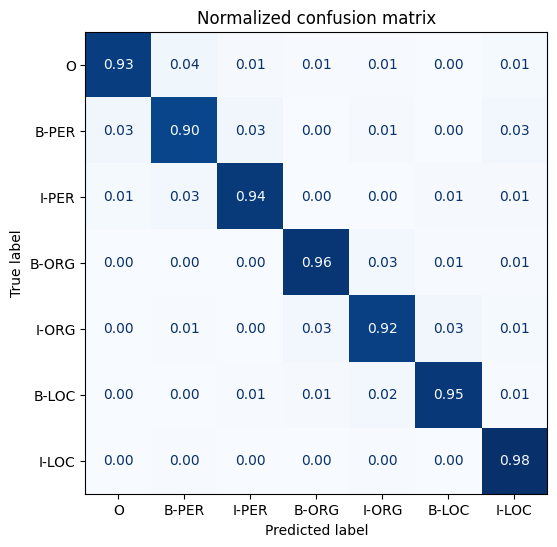

In [72]:
plot_confusion_matrix(df_tokens["labels"], df_tokens["predicted_label"],
                      tags.names)

### review about the context of the location : postive or negative or natural

> this part is just prove of the concept, we can say MVP /
> we can further work more in this part, and the most important question is what is the context of the entity ? fixid linght or all the example or all the sentance ? what if the sentence have more than entity and every one in different sides ?  

In [73]:
# Specify the model to use for Arabic text classification
model_name = "CAMeL-Lab/bert-base-arabic-camelbert-da-sentiment"
classifier = pipeline("text-classification", model=model_name)

config.json:   0%|          | 0.00/841 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/436M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/86.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/305k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

In [74]:
def prediction(text, tags, model_ner, model_sen):
    # Get tokens with special characters
    tokens = xlmr_tokenizer(text).tokens()
    # Encode the sequence into IDs
    input_ids = xlmr_tokenizer(text, return_tensors="pt").input_ids.to(device)
    # Get predictions as distribution over 7 possible classes
    outputs = model_ner.model(input_ids)[0]
    # Take argmax to get most likely class per token
    predictions = torch.argmax(outputs, dim=2)
    
    sentement = model_sen(text)
    
    # tags
    preds = [tags.names[p] for p in predictions[0].cpu().numpy()]
 
    loc = []
    for token,tag in zip(tokens,preds):
        if tag in ["B-LOC","I-LOC"]:
            loc.append(token)
            
    if len(loc) == 0:
        return pd.DataFrame({"words": None, "label": None, "score": None})
        
    label = sentement[0]['label'] 
    score = sentement[0]['score']

    return pd.DataFrame({"words": [loc], "label": label, "score": score})

In [75]:
# test
text = """ذهبت إلى محافظة القاهرة وكنت أشعر بالسعادة
          ثم اتجهت الى مدينة نصر وكان الأمر مجهد
          ثم اتجهت إلى عين شمس حيث مكان بيت جدي
          وسعدت بلقائهم ولكني حزنت لمرض جدي
          وقضيت معهم بعض الوقت
          ثم رجعت إلى الصعيد حيث بيتي
          وشعرت ببعض الراحة حينما شاهدت امي وابي
          """

df = prediction(text, tags, trainer, classifier)
df

,words,label,score
0,"[▁القاهرة, ▁نصر, ▁عين, ▁شمس]",positive,0.873898


> we can go more and more but this good for our first version